## Data Analysis and Preparation of Amazon Fine Food reviews


This notebook will discuss the overall structure of the amazon fine food reviews taken from this kaggle page: https://www.kaggle.com/snap/amazon-fine-food-reviews/data <br>


The metadata of the column is as below:<br>
Id<br>
ProductId - unique identifier for the product<br>
UserId - unqiue identifier for the user<br>
ProfileName<br>
HelpfulnessNumerator - number of users who found the review helpful<br>
HelpfulnessDenominator - number of users who indicated whether they found the review helpful<br>
Score - rating between 1 and 5<br>
Time - timestamp for the review<br>
Summary - brief summary of the review<br>
Text - text of the review<br>

The notebook will also attempt to do some feature engineering and observe if the engineered features are of interest for use in creating the predictive model. 

### -----After Meeting with Chirag--------

Things to add <br>
1) normalized ratings per user id. Group each userid and instead of the raw score, put in a value [-2,2] such that it shows deviation from the user average. <br>
2) analyze types of mistakes the CNN makes. <br>
3) limit vocabs (x number of most common words excluding stop words)<br>
4) visualize most common words in each rating group.


In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


input_location = '/Users/momori/Downloads/amazon-fine-food-reviews/reviews.csv'
output_location = '/Users/momori/Downloads/amazon-fine-food-reviews/reviews_processed.csv'

First off we will load the data into a pandas dataframe then analyze the data. Couple of things we want to check here are the below: <br>
- distribution of the HelpfulnessNumerator/HelpfulnessDenominator/Score
- create a new column for HelpfulnessRatio, which is HelpfulnessNumerator/HelpfulnessDenominator for each Id
- Create a new feature named 'normalized_score' which will be explained below.

In [2]:
data = pd.read_csv(input_location)
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [4]:
#create the HelpfulnessRatio column 
data['HelpfulnessRatio'] = data['HelpfulnessNumerator']/data['HelpfulnessDenominator']
data['HelpfulnessRatio'].describe()

count    298402.000000
mean          0.776975
std           0.346321
min           0.000000
25%           0.600000
50%           1.000000
75%           1.000000
max           3.000000
Name: HelpfulnessRatio, dtype: float64

Now that we have the data and the HelpfulnessRatio, we will plot the data to check the distribution.  This will help in determining any possible outliers which wouldn't help on creating a predictive model.  

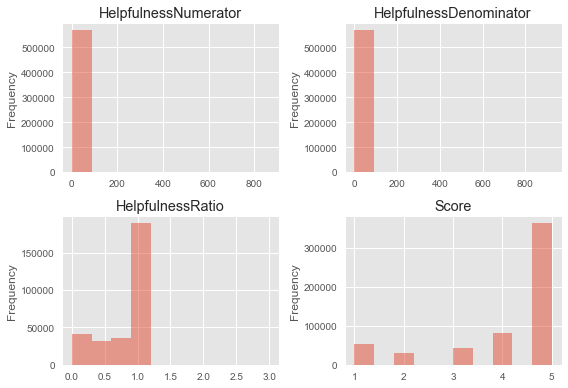

In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(2,2,1)
data['HelpfulnessNumerator'].plot.hist(alpha=0.5)
ax1.set_title('HelpfulnessNumerator')

ax2 = fig.add_subplot(2,2,2)
data['HelpfulnessDenominator'].plot.hist(alpha=0.5)
ax2.set_title('HelpfulnessDenominator')

ax3 = fig.add_subplot(2,2,3)
data['HelpfulnessRatio'].plot.hist(alpha=0.5)
ax3.set_title('HelpfulnessRatio')

ax4 = fig.add_subplot(2,2,4)
data['Score'].plot.hist(alpha=0.5)
ax4.set_title('Score')


plt.tight_layout()

plt.show()

As seen above, the histograms for Helpfulness columns are not informative due to some outliers.  Instead of a histogram, we will utilize a boxplot to better see the distribution and the different quantiles

Helpfulness Numerator quantiles
0.700     1.0
0.800     2.0
0.900     4.0
0.950     7.0
0.990    19.0
0.995    30.0
Name: HelpfulnessNumerator, dtype: float64


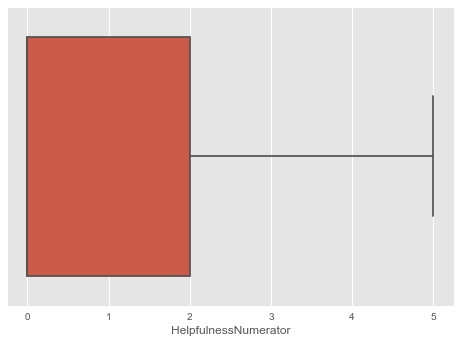

In [6]:
print 'Helpfulness Numerator quantiles'
print data['HelpfulnessNumerator'].quantile([0.7,0.8,0.9, 0.95, 0.99, 0.995])

ax = sns.boxplot(x=data['HelpfulnessNumerator'], showfliers=False)
plt.show()

Helpfulness Denominator quantiles
0.700     2.0
0.800     3.0
0.900     5.0
0.950     9.0
0.990    23.0
0.995    35.0
Name: HelpfulnessDenominator, dtype: float64


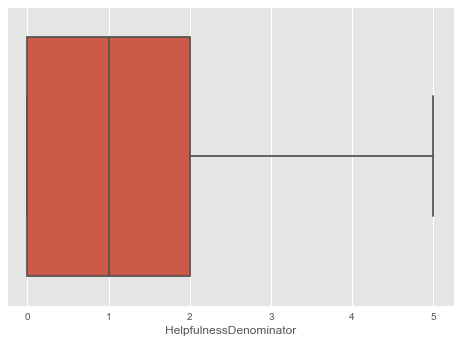

In [9]:
print 'Helpfulness Denominator quantiles'
print data['HelpfulnessDenominator'].quantile([0.7,0.8,0.9, 0.95, 0.99, 0.995])

ax = sns.boxplot(x=data['HelpfulnessDenominator'], showfliers=False)
plt.show()

Helpfulness Ratio quantiles
0.700    1.0
0.800    1.0
0.900    1.0
0.950    1.0
0.990    1.0
0.995    1.0
Name: HelpfulnessRatio, dtype: float64


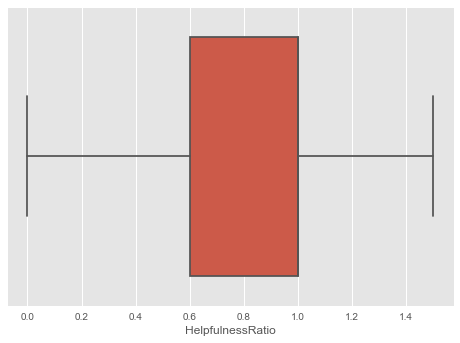

In [19]:
print 'Helpfulness Ratio quantiles'
print data['HelpfulnessRatio'].quantile([0.7,0.8,0.9, 0.95, 0.99, 0.995])

ax = sns.boxplot(x=data['HelpfulnessRatio'], showfliers=False)
plt.show()

We notice from the above boxplots that most values of helpfulness numerator/denominator is covered by values less than 5.  We can probably just utilize these data and discard the rest. But the other thing to notice from the boxplots is that for some of the reviews, the numerators is higher than the denominator (ratio is > 1.0), which doesn't make sense.  We need to look at these data a bit closer and remove them just in case.

In [7]:
d_inspect = data[data['HelpfulnessRatio']>1.0]
d_inspect

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,1.5
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,3.0


Two rows in total has this problem, we will take these two rows out of the dataset.

In [8]:
print '# rows before drop', data.shape[0]
processed_data = data.drop([44736, 64421])
print '# rows after drop', processed_data.shape[0]

# rows before drop 568454
# rows after drop 568452


## normalized ratings per user 

Since different users can be biased towards certain ratings (users who tend to give 5 if they are satisfied vs users who give 4 for the same level of satisfaction),  the data will be grouped into users and the average will be calculated.  

The average score for each user will be used to calculate the deviation away from their average, and set as the column normalized_score. (ex: If user alpha gave three reviews, 2, 2, 5, which averages to an average_score of 3, the normalized_score would be -1,-1, 2 respectively).

The normalized score will be calculated by the following steps:<br>
- Create a series which will show the average score for each UserID by using groupby and mean()
- Join the series to the original dataframe to create avg_score and normalized_score columns
<br>
Then the normalized_score column will be checked for distribution to see if it will add any value to the training data

In [11]:
#for users with multiple reviews, get the average score they've given
#active_users = user_review_counts[user_review_counts.values > 1]

average_scores = data[['UserId','Score']]\
    .groupby('UserId').mean()


In [12]:
#the average_scores dataframe need to be joined with the original df to create new columns, then the
#empty rows (which are users with only 1 review) will be filled with 0
#average_scores = average_scores.rename(columns={'Score','average_score'})
average_scores.columns = ['avg_score']
tmp_data = pd.merge(data, average_scores, how='left', left_on="UserId", right_index=True)
tmp_data['normalized_score'] = tmp_data['Score']-tmp_data['avg_score']

In [13]:
tmp_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,avg_score,normalized_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,5.000000,0.000000
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN,1.000000,0.000000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,4.333333,-0.333333
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,2.000000,0.000000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN,5.000000,0.000000
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,NaN,4.000000,0.000000
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,NaN,3.500000,1.500000
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,NaN,5.000000,0.000000
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,5.000000,0.000000
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,NaN,5.000000,0.000000


We will plot the distribution of normalized_score to see if there is enough data spread to use in the training data.  If the data is not spread enough, then there is not enough variance in the data to make any good inference, and thus most likely will not add much value to training the model

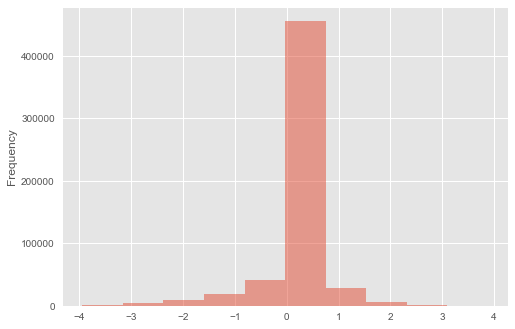

In [17]:
fig = plt.figure()

tmp_data['normalized_score'].plot.hist(alpha=0.5)
plt.show()

from the above histogram, we can see that roughly 450000 (out of 568454 data points) are around 0.  It doesn't seem there is enough variance in this column to add any value.  We will ignore this column when creating the model in the next notebook

## save the data out into a csv for use in modeling.py


In [18]:
tmp_data.to_csv(output_location)